In [70]:
from qiskit import *
from qiskit.circuit import Parameter
from qiskit.visualization import plot_histogram
import numpy as np
import matplotlib
import scipy
from itertools import combinations
import matplotlib.pyplot as plt

In [13]:
def addLayer(circ, thetas):
    numQubits = circ.n_qubits
    for i in range(numQubits):
        circ.rz(thetas[i],i)
        
    if numQubits > 1:
        for c, t in combinations(range(numQubits),2):
            circ.cz(c,t)
        
    for i in range(numQubits):
        circ.rx(thetas[i],i)
        
def getCircuit(numQubits, numLayers):
    thetas = [[Parameter(f'θ[{i},{j+1}]') for j in range(numQubits)] for i in range(numLayers)]
    thetas = np.array(thetas)
    
    circ = QuantumCircuit(numQubits)
    for i in range(numLayers):
        addLayer(circ, thetas[i])
        circ.barrier()
        
    return circ, thetas
        
def generatePsi(numQubits, numLayers, thetaValues):
    circ, parameters = getCircuit(numQubits, numLayers)
    
    parameter_binds={}
    n,m = parameters.shape
    for i in range(n):
        for j in range(m):
            parameter_binds[parameters[i][j]] = thetaValues[i][j]
    
    simulator = Aer.get_backend('statevector_simulator')
    return execute(circ, simulator, parameter_binds=[parameter_binds], shots=1024).result().get_statevector(circ)

def generateRandomState(size):
    vector = np.random.random(size) + np.random.random(size) * 1j
    norm = np.linalg.norm(vector)
    return vector/norm


In [84]:
def cost(flattenedThetas, numQubits, numLayers, fi):
    thetas = flattenedThetas.reshape(numLayers, numQubits)
    psi = generatePsi(numQubits,numLayers,thetas)
    return np.linalg.norm(psi-fi)

def getMinimum(numQubits, numLayers, fi, numTries, method):
    def oneTry():
        start = np.random.uniform(low=0, high=2*np.pi, size=(numQubits*numLayers,))
        res = scipy.optimize.minimize(cost, start,(numQubits, numLayers, fi), method=method)
        return res.fun
    
    minim=oneTry()
    
    tries=1
    while tries<numTries:
        res = oneTry()
        if minim > res:
            minim = res
        tries += 1
    return minim

def doExperiments(qubitCounts, layerCounts, numTries, method):
    results = {}
    for numQubits in qubitCounts:
        fi = generateRandomState(2**numQubits)

        label = f'{numQubits} Qubits'
        results[label] = np.zeros(len(layerCounts))
        for i, numLayers in enumerate(layerCounts):
            results[label][i] = getMinimum(numQubits, numLayers, fi, numTries, method)

    return results

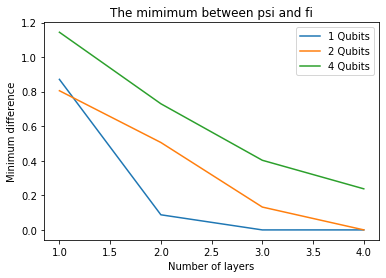

In [85]:
qubitCounts = [1,2,4]
layerCounts = [1,2,3,4]
numTries = 3
method = 'COBYLA'

results = doExperiments(qubitCounts, layerCounts, numTries, method)
plot(results, len(layerCounts))

In [77]:
def plot(results, layersTried):
    x = range(1, layersTried+1)

    for key in results.keys():
        y = results[key]
        plt.plot(x, y, label=key)

    plt.xlabel('Number of layers')
    plt.ylabel('Minimum difference')
    plt.title('The mimimum between psi and fi')
    plt.legend()
    plt.show()

In [137]:
# def cost(theta):
#     psi = generatePsiOneLayer(theta[0], theta[1], theta[2], theta[3])
#     return np.linalg.norm(psi-fi)
    
# start = np.random.uniform(low=0, high=2*np.pi, size=(4,))
# res = scipy.optimize.minimize(cost, start, method='Nelder-Mead')
# res

 final_simplex: (array([[4.93823265, 5.62600736, 4.08638887, 2.93643434],
       [4.9382118 , 5.62610462, 4.08632564, 2.93648374],
       [4.93823723, 5.62600619, 4.08631111, 2.93646639],
       [4.93820811, 5.62601928, 4.0863378 , 2.93649545],
       [4.93813918, 5.62609026, 4.08631114, 2.93652383]]), array([0.91815234, 0.91815234, 0.91815234, 0.91815235, 0.91815235]))
           fun: 0.9181523397796332
       message: 'Optimization terminated successfully.'
          nfev: 139
           nit: 81
        status: 0
       success: True
             x: array([4.93823265, 5.62600736, 4.08638887, 2.93643434])

In [133]:
cost([2.52458136, 2.18068981, 4.0635977 , 1.54155779])


0.8990668053466107

In [72]:
[1:2]

SyntaxError: invalid syntax (<ipython-input-72-1c7b5ee1ef5d>, line 1)

In [66]:
np.linalg.norm(psi-fi)

1.365507537993799

In [237]:
c, t = getCircuit(3,2)
c.draw()

┌────────────┐      ┌────────────┐               ░ ┌────────────┐      »
q_0: ┤ RZ(θ[0,1]) ├─■──■─┤ RX(θ[0,1]) ├───────────────░─┤ RZ(θ[1,1]) ├─■──■─»
     ├────────────┤ │  │ └────────────┘┌────────────┐ ░ ├────────────┤ │  │ »
q_1: ┤ RZ(θ[0,2]) ├─■──┼───────■───────┤ RX(θ[0,2]) ├─░─┤ RZ(θ[1,2]) ├─■──┼─»
     ├────────────┤    │       │       ├────────────┤ ░ ├────────────┤    │ »
q_2: ┤ RZ(θ[0,3]) ├────■───────■───────┤ RX(θ[0,3]) ├─░─┤ RZ(θ[1,3]) ├────■─»
     └────────────┘                    └────────────┘ ░ └────────────┘      »
«     ┌────────────┐               ░ 
«q_0: ┤ RX(θ[1,1]) ├───────────────░─
«     └────────────┘┌────────────┐ ░ 
«q_1: ──────■───────┤ RX(θ[1,2]) ├─░─
«           │       ├────────────┤ ░ 
«q_2: ──────■───────┤ RX(θ[1,3]) ├─░─
«                   └────────────┘ ░

In [284]:
psi = generatePsi(3,2,[[np.pi, np.pi/2, np.pi/3],[np.pi/3, np.pi/4, np.pi]])
np.linalg.norm(fi)

1.0

In [308]:
p = generatePsi(4,3,[[4.5912527 ,  1.58697777,  4.88585462,  4.49225959],  [6.08829631,
        6.63230784,  3.63558275,  6.95567655],  [2.20537385, -1.53319168,
        5.28154685,  1.16467469]])
np.linalg.norm(p-fi)

0.36941506072438274